In [1]:
#load dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load in the collected data
df = pd.read_json('dataframes/reddit_data.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14770 entries, c1e4o to c0i10ti
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   score             14770 non-null  int64 
 1   controversiality  14770 non-null  int64 
 2   subreddit         14770 non-null  object
 3   body              14770 non-null  object
 4   month             14770 non-null  int64 
 5   year              14770 non-null  int64 
 6   original_size     14770 non-null  int64 
 7   PS                14770 non-null  int64 
 8   XBOX              14770 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.1+ MB


In [3]:
print(df.head())

       score  controversiality    subreddit  \
c1e4o      7                 0   reddit.com   
c3kh6      2                 0  programming   
c5iqp      7                 0   reddit.com   
c5vr3      3                 0   reddit.com   
c5zhh     -9                 0   reddit.com   

                                                    body  month  year  \
c1e4o  The article raises concerns that a single spee...      2  2006   
c3kh6  Linkjack. [Here](http://www.macworld.com/2005/...      3  2006   
c5iqp  Do you feel that now that we have discovered t...      5  2006   
c5vr3  &gt;What makes Nintendo Wii special and differ...      5  2006   
c5zhh  I don't know about you fags, but I've never be...      5  2006   

       original_size  PS  XBOX  
c1e4o           9095   0     1  
c3kh6          13859   1     0  
c5iqp          26859   1     0  
c5vr3          26859   1     1  
c5zhh          26859   0     1  


In [4]:
print(df.describe())

              score  controversiality         month          year  \
count  14770.000000      14770.000000  14770.000000  14770.000000   
mean       2.907380          0.001016      8.206974   2008.741368   
std       11.100893          0.031853      3.300450      0.532384   
min      -45.000000          0.000000      1.000000   2006.000000   
25%        1.000000          0.000000      6.000000   2009.000000   
50%        1.000000          0.000000      9.000000   2009.000000   
75%        3.000000          0.000000     11.000000   2009.000000   
max      398.000000          1.000000     12.000000   2009.000000   

       original_size            PS          XBOX  
count   1.477000e+04  14770.000000  14770.000000  
mean    1.588857e+06      0.446445      0.611916  
std     7.252841e+05      0.497140      0.487330  
min     9.095000e+03      0.000000      0.000000  
25%     1.048643e+06      0.000000      0.000000  
50%     1.750688e+06      0.000000      1.000000  
75%     2.207444e+06 

Before we get into exploring the data, I'm going to add a few columns to add meaning.  
PS and XBOX columns are boolean integers representing whether or not it is expressed in a post,
so the first two columns I'm going to add are Count columns to represent the rolling cumulative amount of posts
for that console, represented as percents of total Reddit posts.
The third one I'm adding is a Date column that will be unifying the Month and Year columns into one value,
making it easier to check trends over time.

In [5]:
df['PS_Count'] = df['PS'].cumsum() * 100 / df['original_size']
df['XBOX_Count'] = df['XBOX'].cumsum() * 100 / df['original_size']

df['date'] = df['month'].astype(str) + '/' + df['year'].astype(str)
df['date'] = pd.to_datetime(df['date'])

print(df[['PS_Count', 'XBOX_Count', 'date']].head())

       PS_Count  XBOX_Count       date
c1e4o  0.000000    0.010995 2006-02-01
c3kh6  0.007216    0.007216 2006-03-01
c5iqp  0.007446    0.003723 2006-05-01
c5vr3  0.011169    0.007446 2006-05-01
c5zhh  0.011169    0.011169 2006-05-01


First let's take a look at the correlation of numeric and boolean.
Original_size is just the number of posts in that year/month combination and
will not be useful in looking at correlations.

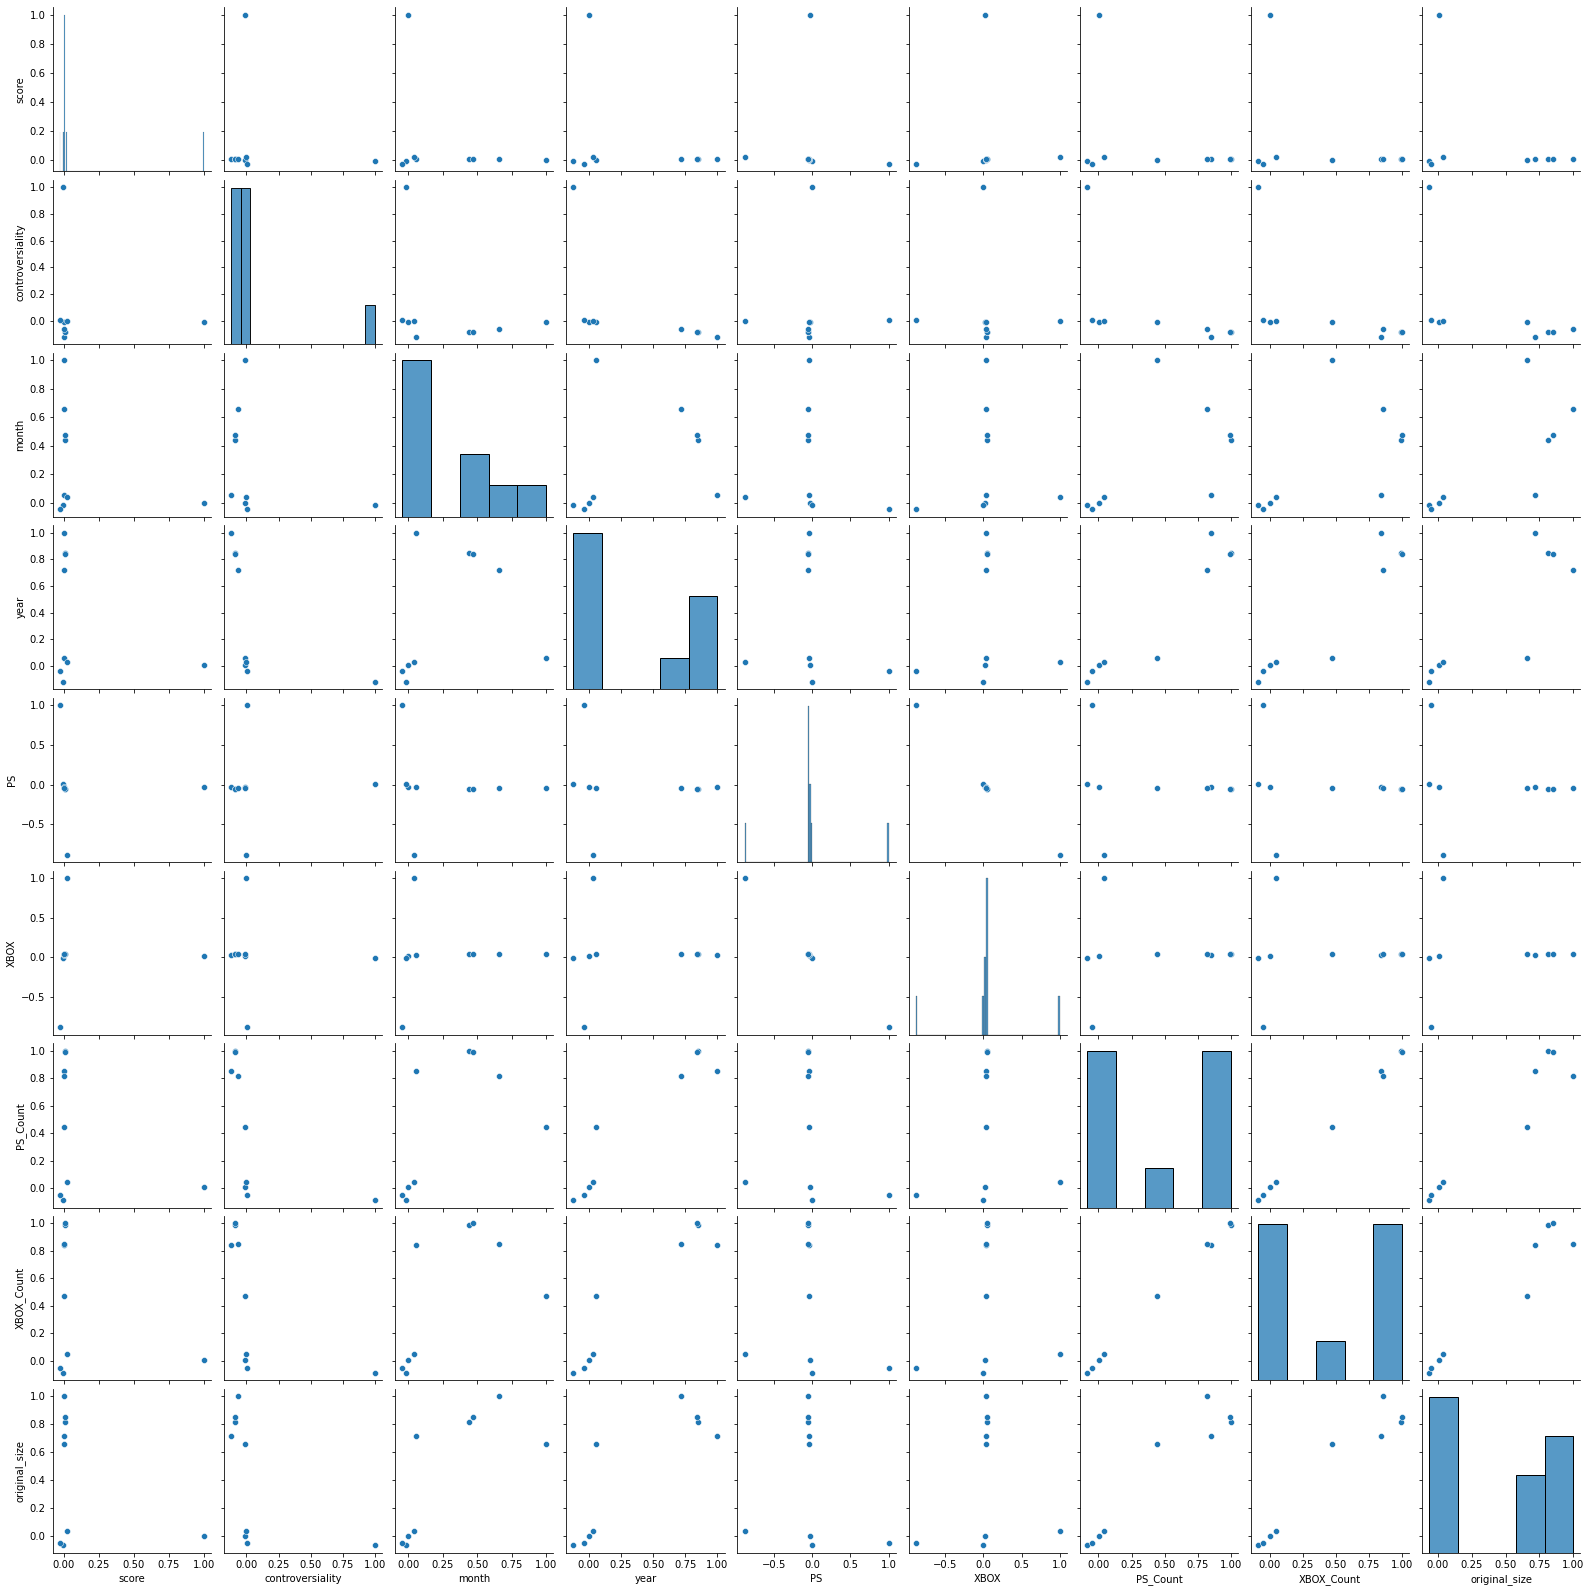

In [6]:
corr_df = df[['score', 'controversiality', 'month', 'year', 'PS', 'XBOX', 'PS_Count', 'XBOX_Count', 'original_size']]
sns.pairplot(corr_df.corr())
plt.show()

This is a bit rough to look at, since PS and XBOX are binary in nature, PS and XBOX Counts are sums of the
previously mentioned columns, original_size grows exponentially with time, and month values are repeated over time.
To make it a bit easier to understand, let's look at it as a heatmap.

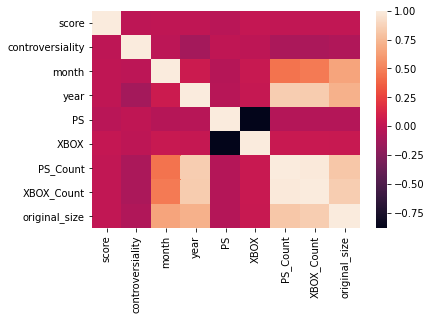

In [7]:
sns.heatmap(corr_df.corr())
plt.show()

PS_Count and XBOX_Count have a strong positive correlation with year, each other, and slightly with month and
original_size, as both useage of Reddit since its inception in 2005 and talk of the consoles have increased over the years.  
Interestingly enough, as both PS_Count and XBOX_Count are percents of overall Reddit comments, 
they have become more popular topics of conversation as time goes on.  
Furthermore, despite the Count columns being positively correlated, the PS and XBOX columns
have a strong negative correlation, though I suspect this is because they are binary values, and the database
is made up of any comment that contains at least one of the two, leaving a lot of 1,0 and 0,1 combinations while
leaving out any 0,0 combinations.

As one might expect, controversiality and score are negatively correlated.
Looking at the heatmap below, they're negatively correlated with everything else as well.
This is because controversiality only has two values: 0 and 1, the latter only shows up 15 times, 
all of which were in 2006 and 2007.
Score, meanwhile has a wide variance, with about 11k/14.5k entries being between 0 and 4 but overall
ranging from -45 to 398, so its outliers have an unjust control over the correlations.

To visualize Score's data with and without outliers, I made the histograms below.

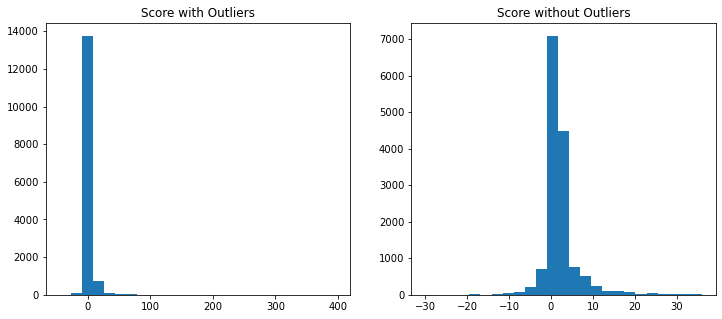

In [8]:
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
bins = 25
axs[0].hist(df['score'], bins=bins)

m = df['score'].mean()
std = 3 * df['score'].std()
axs[1].hist(df['score'][(df['score'] >= (m-std)) & (df['score'] <= (m+std))], bins=bins)

axs[0].set_title('Score with Outliers')
axs[1].set_title('Score without Outliers')
plt.show()

Below I am plotting the number of instances of PS and XBOX comments over time.

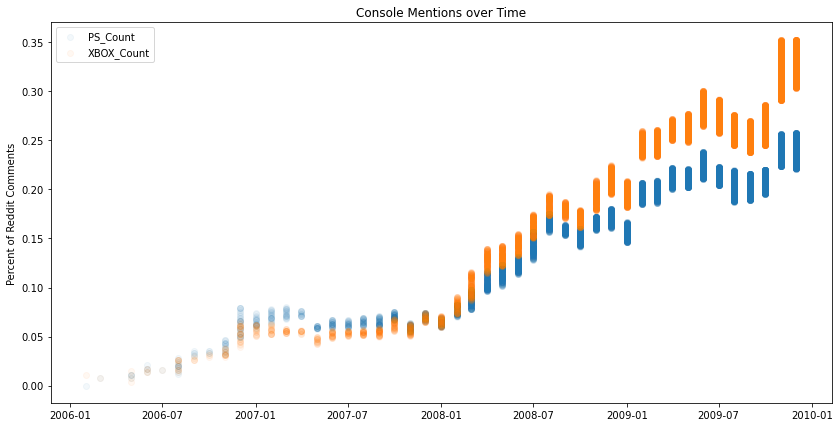

In [9]:
plt.figure(figsize=(14,7))
plt.scatter('date', 'PS_Count', data=df, alpha=0.05)
plt.scatter('date', 'XBOX_Count', data=df, alpha=0.05)

plt.legend()
plt.title('Console Mentions over Time')
plt.ylabel('Percent of Reddit Comments')
plt.show()

Since there wasn't a day of the month included in the data, the graph above has a step function appearance.
Both sets scale exponentially due to more frequent use of Reddit as time goes on, 
hence the percentage of mentions rather than count.
It looks like PS has a slight lead in mentions initially, but XBOX eventually took over in early 2008.
Percent of Reddit Comments are all less than 1% for clarification.

Next, let's take a look at how post frequency varies per month.

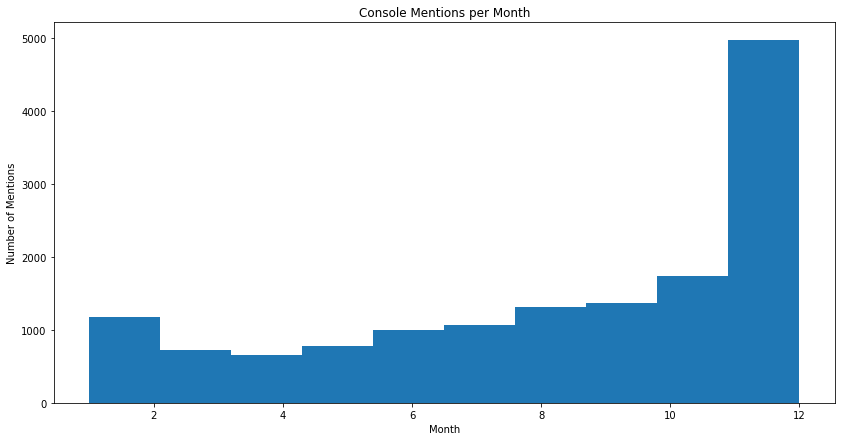

In [10]:
plt.figure(figsize=(14,7))
plt.hist('month', data=df)

plt.title('Console Mentions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Mentions')
plt.show()

While part of the uptick in later months could be attributed to the overall increase of posts over time,
I suspect that the number of posts drastically increases in late fall due to higher interest near the holidays;
as new console and game releases tend to be in early November so they can be on shelves before Black Friday
shoppers buy them as Christmas presents.

Another interesting thing we could look at is how score and controversy change over time.

[]

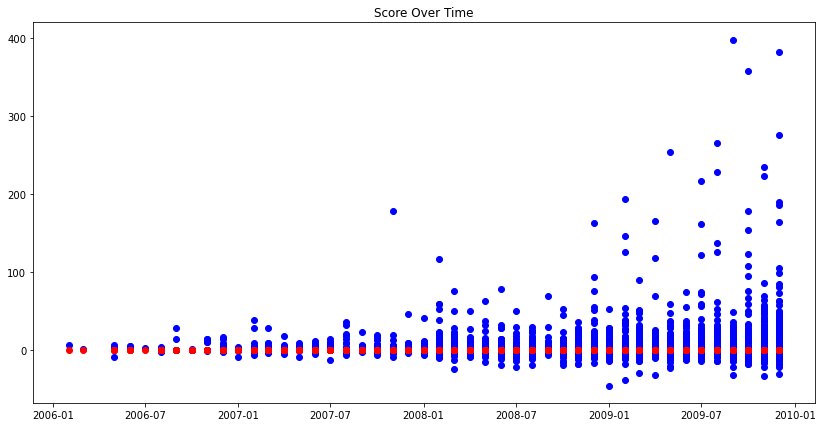

In [11]:
plt.figure(figsize=(14,7))
plt.scatter('date', 'score', data=df, color='blue')
plt.scatter('date', 'controversiality', data=df, color='red')
plt.title('Score Over Time')
plt.plot()

Looking at the score, it now makes more sense as to why there are so many outliers.
Since Reddit was created in 2005, not many users were on the website to vote in the earlier
years, but as time goes on there are more users and more popular conversations to vote on.
Controversiality varies little, so it is more or less showing the baseline score of 0-1 in this case.

Next, I want to take a look at how mentions are spread out over different Subreddits.

In [12]:
#plotting Counts by Subreddit

#create a filtering mask to only show subreddits that have more than 10 mentions apiece to avoid an oversized graph
subreddit_mask = df['subreddit'].value_counts() > 10
subreddit_mask.replace(False, np.nan, inplace=True)
subreddit_mask.dropna(inplace=True)
subreddit_df = df[df['subreddit'].isin(subreddit_mask.index)]

subreddit_df['PS_Subreddit_Count'] = subreddit_df['subreddit']
subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['subreddit']
for subreddit in subreddit_mask.index:
    base_df = subreddit_df[subreddit_df['subreddit']==subreddit]
    ps_sub = base_df[base_df['PS']==True]
    xbox_sub = base_df[base_df['XBOX']==True]
    ps_count = ps_sub['PS'].count()
    xbox_count = xbox_sub['XBOX'].count()

    subreddit_df['PS_Subreddit_Count'].replace(subreddit, str(ps_count), inplace=True)
    subreddit_df['XBOX_Subreddit_Count'].replace(subreddit, str(xbox_count), inplace=True)
    
subreddit_df['PS_Subreddit_Count'] = subreddit_df['PS_Subreddit_Count'].astype(int)
subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['XBOX_Subreddit_Count'].astype(int)

<ipython-input-12-6190ae284e5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df['PS_Subreddit_Count'] = subreddit_df['subreddit']
<ipython-input-12-6190ae284e5f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['subreddit']
C:\Users\rlybb\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

<ipython-input-13-281cf78354da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df.sort_values(by='XBOX_Subreddit_Count', inplace=True, ascending=False)


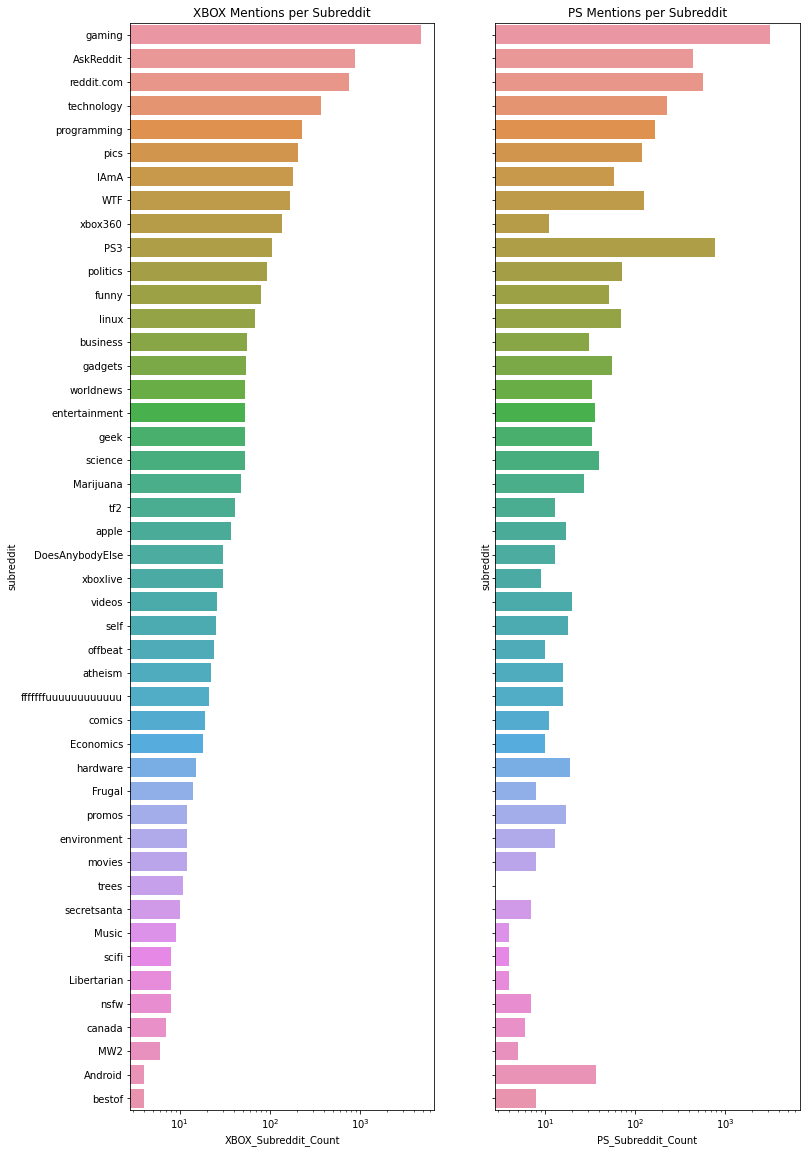

In [13]:
subreddit_df.sort_values(by='XBOX_Subreddit_Count', inplace=True, ascending=False)

figs, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 20))
sns.barplot(x='XBOX_Subreddit_Count', y='subreddit', data=subreddit_df, ax=axs[0])
axs[0].set_title('XBOX Mentions per Subreddit')
axs[0].set_xscale('log')

sns.barplot(x='PS_Subreddit_Count', y='subreddit', data=subreddit_df, ax=axs[1])
axs[1].set_title('PS Mentions per Subreddit')
plt.show()

The above barplots separate number of mentions by subreddit.  
Unsurprisingly, Gaming is the most popular subreddit for both XBOX and PS, 
followed by PS3 for PS, askreddit and reddit.com, technology, and programming.
Note that reddit.com is a placeholder for posts before subreddits were created in 2008.
Once again, the data is shown on a logarithmic scale due to the exponential behavior of posts on Reddit.

Onto displaying the body column.  As this represents the actual Reddit comments, EDA is a bit tricky.
In this case, I'll be running TextBlob's sentiment function to get a feel for the average mood of different
posts, and creating a word cloud to show the most frequent words used.

In [14]:
from textblob import TextBlob

def sentiment_analysis(paragraph):
    body_text = TextBlob(paragraph)
    return(body_text.sentiment[0])

def paragraph_cleanse(paragraph):
    #modify contractions
    paragraph = paragraph.replace("'", "")
    
    #lowercase everything
    paragraph = paragraph.lower()
    
    #remove punctuation and excess spacing
    for char in ['`', '~', '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '=', '+', '[', '{', ']', '}', '|',
                 '\\', ':', ';', '"', ',', '<', '.', '>', '/', '?']:
        paragraph = paragraph.replace(char, ' ')
        paragraph = paragraph.replace('  ', ' ')
    
    return(paragraph)
        
df['naive_sentiment'] = df['body'].apply(sentiment_analysis)
df['body'] = df['body'].apply(paragraph_cleanse)

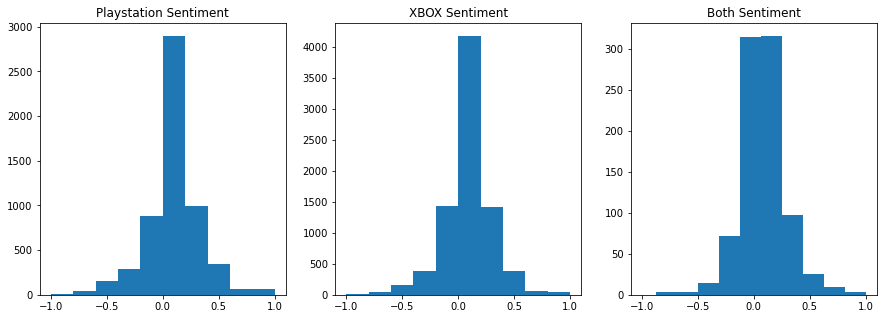

In [15]:
figs, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(15, 5))
axs[0].hist(df['naive_sentiment'][(df['PS']==True) & (df['XBOX']==False)])
axs[1].hist(df['naive_sentiment'][(df['XBOX']==True) & (df['PS']==False)])
axs[2].hist(df['naive_sentiment'][(df['XBOX']==True) & (df['PS']==True)])

axs[0].set_title('Playstation Sentiment')
axs[1].set_title('XBOX Sentiment')
axs[2].set_title('Both Sentiment')
plt.show()

It looks like the ratio of each console's sentiment is roughly the same,
with PS having slightly more values above 0.5
(XBOX has more overall mentions, hence why I didn't set the y-axis to match).
Since both sets have a roughly normal distribution, it makes sense that the overlapping data is also similarly shaped.
Sentiment is measured on a scale of -1 to 1 for clarification.

[]

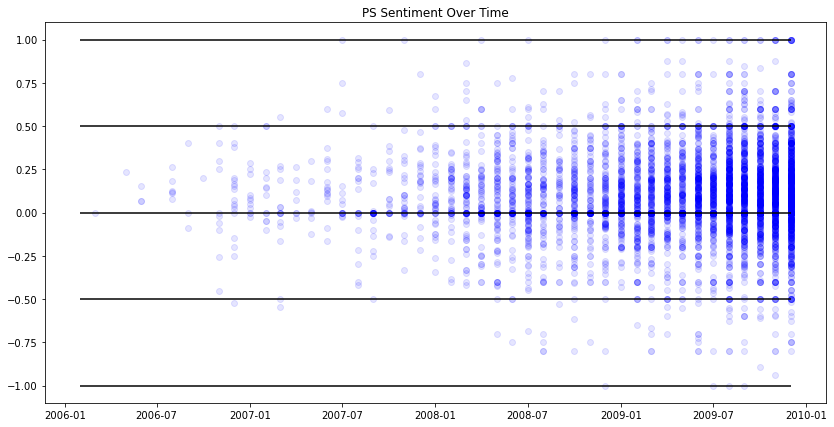

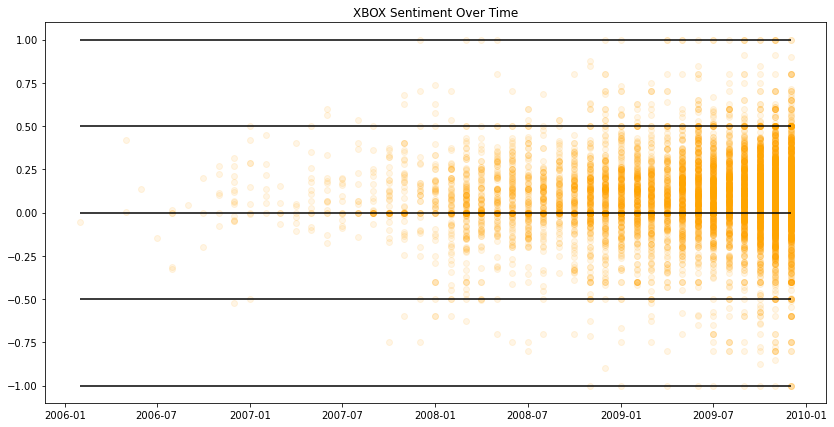

In [16]:
plt.figure(figsize=(14,7))
plt.scatter('date', 'naive_sentiment', data=df[(df['PS']==True) & (df['XBOX']==False)], color='blue', alpha=0.1)
plt.hlines([-1, -0.5, 0, 0.5, 1], xmin=df['date'].min(), xmax=df['date'].max())
plt.title('PS Sentiment Over Time')
plt.plot()

plt.figure(figsize=(14,7))
plt.scatter('date', 'naive_sentiment', data=df[(df['XBOX']==True) & (df['PS']==False)], color='orange', alpha=0.1)
plt.hlines([-1, -0.5, 0, 0.5, 1], xmin=df['date'].min(), xmax=df['date'].max())
plt.title('XBOX Sentiment Over Time')
plt.plot()

Honestly, not much to see here.  Due to the increase of posts over time, the overall polarity of each
post's sentiment varies more, although it is interesting that PS posts seem to be slightly more positive
in the final months of 2010 than XBOX posts.  I also find it interesting that many of the values for both
sets are values of -0.5, 0, 0.5, 1, a pattern that persists over time.

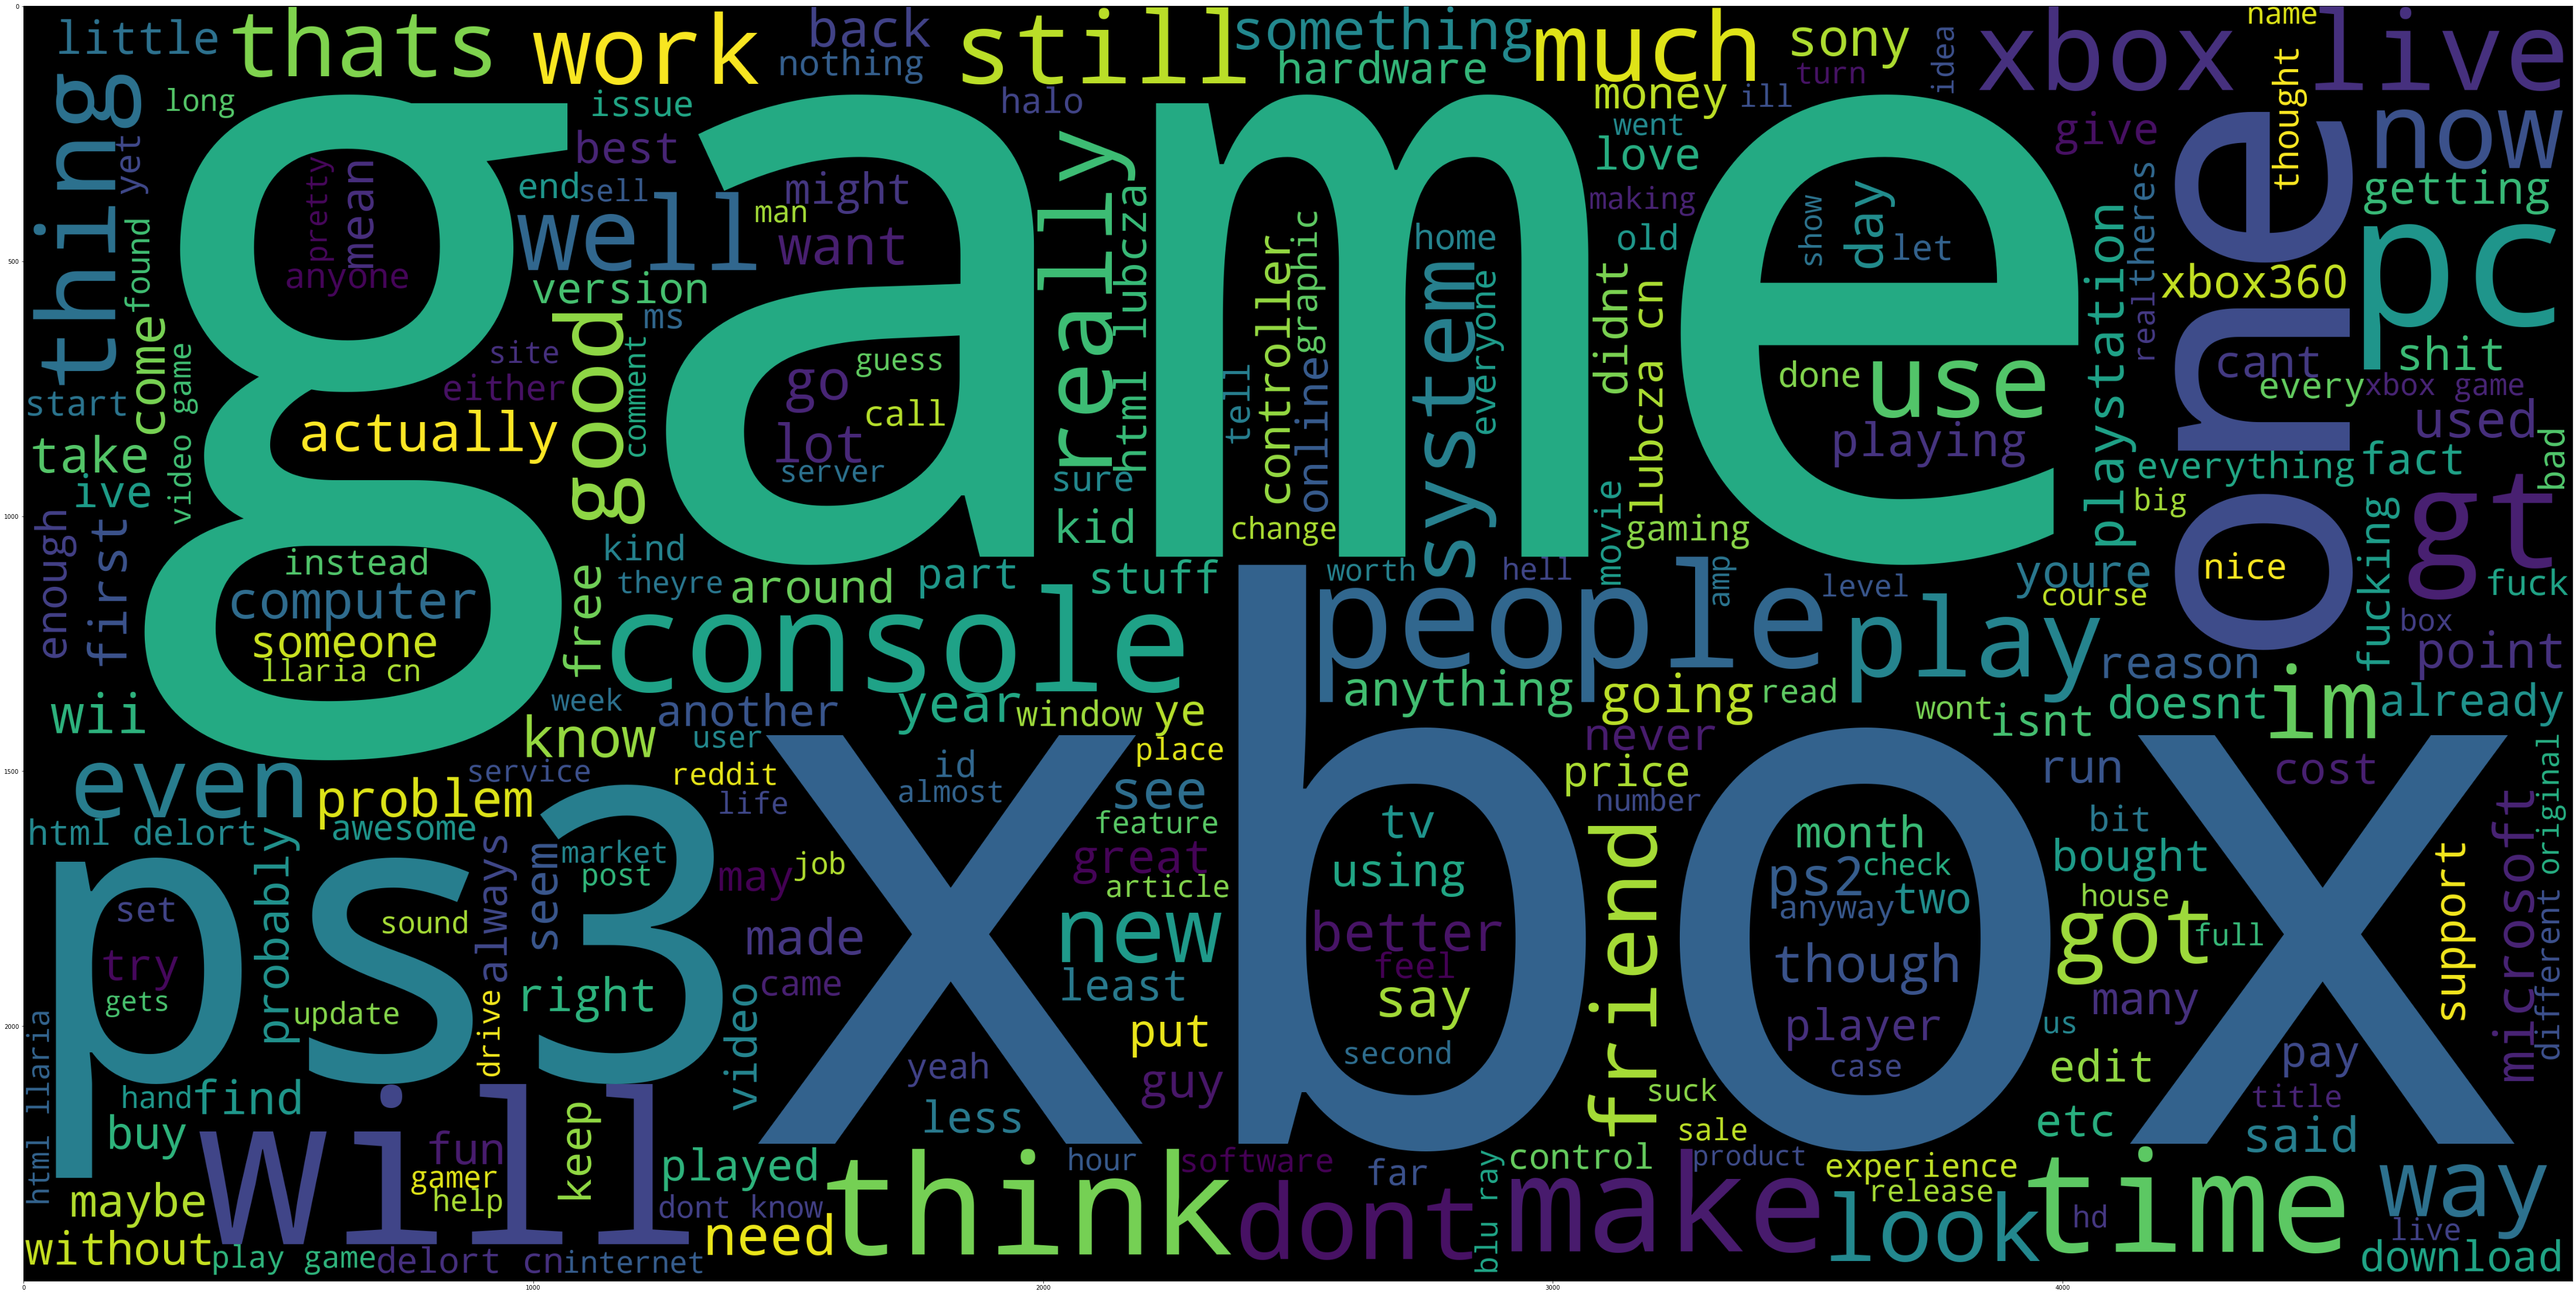

In [17]:
from wordcloud import WordCloud, STOPWORDS

test_range = range(df['body'].count())
stopwords = STOPWORDS
superstring = ""

for i in test_range:
    test_string = df['body'].iloc[i]
    superstring += test_string
    
wc = WordCloud(width=5000, height=2500, max_words=250, stopwords=stopwords).generate(superstring)
plt.figure(figsize=(80, 40))
plt.imshow(wc)
plt.show()

Looking at the top 250 words across all of the posts, there are plenty of phrases you'd expect to see,
such as game, xbox, xbox live, system, ps3, player, download, console, pc, gaming, and play.
Amongst the remaining words, we can see some indications of positive sentiment, such as awesome, love, new, great,
original, need, good, and pretty, although there is a fair amount of negative sentiment found in words like
never, dont, old, problem, doesnt, suck, issue, wont, and a few swear words that I won't bother listing.
These are the types of phrases my machine learning will have to sift through in order to properly score
each post.

In [18]:
#Saving the fact that I added a few columns like date and naive_sentiment.
df.to_json('dataframes/reddit_data.json')